In [1]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
utils = reload(utils)
pt = reload(pt)

import dill as pickle
import sys
import os
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../modules/')
sys.path.append('../RKLM_Python/')

import matplotlib.pyplot as plt
from matplotlib import rc

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts,amssymb,bm,mathrsfs}')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.style.use('ggplot')

import matplotlib.colors as mcolors
import matplotlib as mtl

## Helper functions to load and transform solutions

In [19]:
i2 = (slice(2,-2),slice(2,-2))
# i2 = (slice(0,-2),slice(0,-2))

# i2x = (slice(2,-2),slice(0,-1))
# i2x = (slice(0,-2),slice(0,-1))

# i1 = (slice(2,-2))
# i1 = (slice(0,-2))

inner = False

def load(Nx,Ny,et,test):
    if test == 'mark':
        # base_fn = 'output'
        base_fn = 'output_mark_wave'
    # pydir = '../%s/' %base_fn
    pydir = '/home/ray/git-projects/RKLM_Reference/output_mark_wave/'

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
    tags = tc.get_tag_dict()
    
    return tc, tags

def get_ens(tc, times, sfx , diff, attribute, tag, SIDX, NIDX):
    idx = 0 if tag == 'ic' else -1
    times = [0] if tag == 'ic' else times
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=inner,load_ic=True)[idx]

    label = sfx + '_' + attribute
    return label, ens.T[SIDX:NIDX,:]
    # return label, ens.T[SIDX:,:]

def get_ens_all(tc, times, sfx , diff, attribute, tag, SIDX, NIDX):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=inner,load_ic=True)
    ens = ens[:,2:-2,SIDX:NIDX]
    # ens = ens[:,:,SIDX:]
    return ens

# here, we load the time series of the simulations
def get_tc(typ, times, Nx, Ny, NIDX, tp='half', test='mark', et=8000.0):
    sfx1 = '%s' %typ

    tc, tags = load(Nx,Ny,et,test)
    if tp=='afs':
        tag = 'after_full_step'
    else:
        tag = tp
        
    print(sfx1, et, tp)

    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

#     print(path_pickle)
    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    mpv = pickle.load(file)
    elem = pickle.load(file)
    node = pickle.load(file)
    dap = pickle.load(file)
    file.close()

    _, rho = get_ens(tc, times, sfx1, diff, 'rho', tag, 0, NIDX)
    
    return (ud,mpv,elem,node), tc

# function to recover the transformed variables in dimensional form
def hatter(arrs, ud, mpv, elem, SIDX, NIDX):
    arrs_rhou, arrs_rhov, arrs_rhoY, arrs_pi, rhos = arrs
    # rhobar = mpv.HydroState.rho0[2:-2][SIDX:NIDX]
    rhobar = mpv.HydroState.rho0[SIDX:NIDX]
    # rhobar = mpv.HydroState.rho0[SIDX:]
    uhat = ((arrs_rhou / rhos) - ud.u_wind_speed) * rhobar**0.5 * (ud.u_ref * np.sqrt(ud.rho_ref))
    vhat = arrs_rhov / rhos * rhobar**0.5 * (ud.u_ref * np.sqrt(ud.rho_ref))
    
    # rhos[...] = 1.0
    
    Nfq = ud.Nsq_ref**0.5
    
    print("sz=",uhat.shape)
    print("Nsq=",Nfq)
    g = 9.81
    Ginv = 1.4 / (1.4 - 1.0)
    
    # Ybar = mpv.HydroState.Y0[2:-2][SIDX:NIDX]
    # S0 = (ud.stratification(elem.y)).reshape(1,1,-1)[:,:,2:-2][:,:,SIDX:NIDX]
    
    Ybar = mpv.HydroState.Y0[SIDX:NIDX]
    S0 = (ud.stratification(elem.y)).reshape(1,1,-1)[:,:,SIDX:NIDX]
    # Ybar = mpv.HydroState.Y0[SIDX:]
    # S0 = (ud.stratification(elem.y)).reshape(1,1,-1)[:,:,SIDX:]

    Yhat = g / Nfq * (rhobar**0.5 * np.sqrt(ud.rho_ref)) / Ybar * (arrs_rhoY / rhos - Ybar)
    
    p2c = np.array([signal.fftconvolve(mem,[[1,1],[1,1]], mode='valid')/4.0 for mem in arrs_pi])
    C = np.sqrt(1.4 * ud.u_ref**2/ud.Msq)
    # C = np.sqrt(1.4 * ud.Rg * ud.T_ref)
    print("C=",C)
    p2hat = ud.cp_gas / C * (rhobar**0.5 * np.sqrt(ud.rho_ref)) * Ybar * p2c * ud.T_ref * ud.Msq
    # p2hat = ud.cp_gas / C * (rhobar**0.5 * np.sqrt(ud.rho_ref)) * Ybar * p2c * ud.T_ref
    
    print("c_p=",ud.cp_gas)
    
    # uhat = arrs_rhou / rhos
    # vhat = arrs_rhov / rhos
    # Yhat = arrs_rhoY / rhos - Ybar
    # p2hat = p2c
    
    
    print(p2hat.sum() + uhat.sum() + vhat.sum() + Yhat.sum())
    print(p2hat.sum(), uhat.sum())
    
    return uhat, vhat, Yhat, p2hat

## Output solution plot for each prognostic variable over the first 30 time steps.

In [20]:
l_typ = 'WINDOW_STEP'
# l_typ = 'TIME'

diff = False
attr_labels = pt.labels()

tp ='afs'
tag = 'after_full_step'
time_unit = 's'
N = 1
et = 36.0

times0 = np.arange(0,360)
# times0 = np.arange(0,361,1.0)
# times0 = np.arange(355,360)
# times0 = np.arange(-1,1000,100)[1:]
# times0 = np.arange(1,11,1)-1
# times0 = [0,999,1999,2999,3999,4999,5999,6999]
times0 = np.append([0], times0)
# times0 = np.arange(31,50)

# choose spatial resolution (Nxs, Nys) and temporal resolution (Nts)
# Nxs = [151]
# Nys = [60]
Nxs = [301]
Nys = [120]
# Nxs = [1201]
# Nys = [480]
# Nxs = [1201]
# Nys = [480]
# Nts = [200,400,600,800,1000,1200,1400,1600]
Nts = [10]
# Nts = [10.0]
# Nts = [1200]
# Nts = [1000,1200,1400,1600]
oms = ['', '_noom']
oms = ['']
# oms = ['_noom']

mixed = False

# level of the contours
lu = [-0.02, -0.1, -1.2][::-1] + [-0.01, 0.01] + [0.02, 0.1, 1.2]
lv = [-0.002, -0.01, -0.10][::-1] + [-0.001, 0.001] + [0.002, 0.01, 0.10]
# lrhoY = [-0.02, -0.2, -2.0][::-1] + [-0.01, 0.01] + [0.02, 0.2, 2.0]
lrhoY = lv
lp2n = [-0.2, -1.2, -12.0][::-1] + [-0.1, 0.1] + [0.2, 1.2, 12.0]

# lu = [-0.000024, -0.00024, -2.4][::-1] + [-1e-6, 1e-6] + [0.000024, 0.00024, 2.4]
# lv = [-0.001, -0.01, -1.0][::-1] + [-1e-6, 1e-6] + [0.001, 0.01, 1.0]
# lrhoY = [-0.002, -0.02, -2.0][::-1] + [-1e-6, 1e-6] + [0.002, 0.02, 2.0]



# lrhoY = np.array(lrhoY)
# lrhoY = 10**lrhoY / 0.01
# lrhoY = np.log(lrhoY) + np.log(0.01)
# print(lrhoY)
# lp2n = lu
lvls = np.array([lu,lv,lrhoY,lp2n])
# lvls = lvls*1e-5

# ref: https://stackoverflow.com/questions/61897393/unevenly-irregularly-spaced-data-for-colorbar-with-evenly-spaced-colors
cmap_rb = plt.get_cmap('cubehelix')
lu_colors = cmap_rb(np.linspace(0, 1, len(lu) + 1))
lu_cm, lu_nm = mcolors.from_levels_and_colors(lu, lu_colors, extend='both')

lv_colors = cmap_rb(np.linspace(0, 1, len(lv) + 1))
lv_cm, lv_nm = mcolors.from_levels_and_colors(lv, lv_colors, extend='both')

lrhoY_colors = cmap_rb(np.linspace(0, 1, len(lrhoY) + 1))
lrhoY_cm, lrhoY_nm = mcolors.from_levels_and_colors(lrhoY, lrhoY_colors, extend='both')

lp2n_colors = cmap_rb(np.linspace(0, 1, len(lp2n) + 1))
lp2n_cm, lp2n_nm = mcolors.from_levels_and_colors(lp2n, lp2n_colors, extend='both')
cmaps = [[lu_cm,lu_nm],[lv_cm,lv_nm],[lrhoY_cm,lrhoY_nm],[lp2n_cm,lp2n_nm]]

for Nx, Ny in zip(Nxs,Nys):  
    for Nt in Nts:
        for om in oms:
            if mixed:
                typ = 'mix_run_S%i' %(Nt)
            else:
                typ = 'bdl_run_S%i%s_a05' %(Nt,om)
                # typ = 'test_run_S%i_adv' %(Nt)
                # typ = 'test_run_S%i_mix' %(Nt)
                # typ = 'bottom_forcing_S%i' %Nt
            # typ = 'bdl_test_S%i%s_a1' %(Nt,om)
            ics,tc = get_tc(typ,times0[1:], Nx, Ny, Ny, tp=tp, et=et)
            
            ud, mpv, elem = ics[0], ics[1], ics[2]
            SIDX = np.abs(elem.y - 0.0).argmin()
            NIDX = np.abs(elem.y - 2.5).argmin()
            # NIDX = 
            # NIDX = np.abs(elem.y - 85).argmin()
            
            # SIDX = 0
            # NIDX = None
            # print(NIDX, elem.y[NIDX])
            

            t_axs = np.append(0,times0)
            if l_typ == 'WINDOW_STEP':
                phys_time = tc.t_arr
            else:
                phys_time = times0
            # phys_time = np.append(phys_time)
            # print(phys_time)

            if '_noom_' in typ:
                tcase = 'wo_omega' ## \Omega = 0.0, traditional setting
                tstr = r'0.0'
                fld = 'noom'
            else:
                tcase = 'a05' ## Non-tradtional setting
                tstr = '%.6f' %(ud.coriolis_strength[2] / ud.t_ref/ 2.0)
                fld = 'om'

                
            cnt = 0
            ic_not_loaded = True
            for idx,time in enumerate(times0):
                # print("times0 = ", times0)
                if ((int(time) == 0) and (ic_not_loaded)):
                    tag = 'ic' 
                    ic_not_loaded = False
                    t_name = 0
                else:
                    tag = 'after_full_step'
                    t_name = int(time)
                    if l_typ == 'WINDOW_STEP': t_name += 1
                    
                tt = [time]
                rhos = get_ens_all(tc, tt, typ, False, 'rho', tag, SIDX, NIDX)[:]
                arrs_rhou = get_ens_all(tc, tt, typ, False, 'rhou', tag, SIDX, NIDX)[:]
                arrs_rhov = get_ens_all(tc, tt, typ, False, 'rhov', tag, SIDX, NIDX)[:]
                arrs_rhoY = get_ens_all(tc, tt, typ, False, 'rhoY', tag, SIDX, NIDX)[:]
                if NIDX == None:
                    arrs_pi = get_ens_all(tc, tt, typ, False, 'p2_nodes', tag, SIDX, NIDX)[:]
                else:
                    arrs_pi = get_ens_all(tc, tt, typ, False, 'p2_nodes', tag, SIDX, NIDX+1)[:]

                arrs = [arrs_rhou, arrs_rhov, arrs_rhoY, arrs_pi, rhos]
                arrs_hat = hatter(arrs, ud, mpv, elem, SIDX, NIDX)
                slc_idx = 0 if tt == 0 else -1
                arrs_hat = [arr[slc_idx,...].T for arr in arrs_hat]
                uhat, vhat, Yhat, p2hat = arrs_hat

                ud, mpv = ics[0], ics[1]
                ct = 0.0 if time == 0 else time
                
                if tag == 'ic':
                    print(Yhat.max(),Yhat.min())

                pl_lst = [[uhat, r"$\chi_{u}$"],[vhat, r"$\chi_{w}$"],[Yhat, r"$\chi_{\theta}$"],[p2hat, r"$\chi_{\pi}$"]]
                # pl_lst = [[uhat, r"${u^\prime}$"],[vhat, r"${w^\prime}$"],[Yhat, r"${\theta^\prime}$"],[p2hat, r"${\pi^\prime}$"]]
                pl = pt.plotter(pl_lst,ncols=2,figsize=(30,16),sharey=False, fontsize=32)
                x_axs = np.array(np.linspace(ud.xmin,ud.xmax,7))
                # y_axs = np.array(np.linspace(elem.y[SIDX],elem.y[NIDX-1],6))

                x_axs = np.around(x_axs,2) * 10
                # y_axs = np.around(y_axs,1)

                x_loc = np.linspace(0,(Nx-1),7)
                y_loc = np.linspace(0,uhat.shape[0]-1,6)
                y_axs = np.array([0.0,0.5,1.0,1.5,2.0,2.5]) * 10.0
                
                # y_loc = np.linspace(0,uhat.shape[0]-1,5)
                # y_axs = np.array([0.0,2.0,4.0,6.0,8.0]) * 10.0
                # print(elem.y.shape)
                # y_axs = elem.y[::21]
                
                if NIDX == 121:
                    y_loc = np.linspace(0,NIDX-SIDX-1,5)
                    y_axs = np.array([0.0,2.0,4.0,6.0,8.0]) * 10.0

                x_label = r'$x$ [km]'
                y_label = r'$z$ [km]'

                pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)

                tu = ud.t_ref#/3600
                print([t_name], phys_time[cnt]*tu)
                stitle = r'$t=$%.4f~s; (%i,%i); $\Delta t=$%.2f~s; $\Omega_y=$ %s~s$^{-1}$' %(phys_time[cnt]*tu, Nx,Ny,Nt,tstr)
                # _ = pl.plot(method='contour', lvls=lvls, suptitle=stitle, cmaps=cmaps, rect=[0, 0.03, 1, 0.95])
                _ = pl.plot(method='contour', lvls=None, suptitle=stitle, rect=[0, 0.03, 1, 0.95])
                # _ = pl.plot(method='contour', suptitle=stitle, rect=[0, 0.03, 1, 0.95])
                fld_pth = './output_plot/%ix%i/S%i/%s' %(Nx,Ny,Nt,fld)
                if not os.path.exists(fld_pth):
                    os.makedirs(fld_pth)
                    
                pl.save_fig('%s/lamb_%s_%.3d' %(fld_pth, tcase, t_name), format='.png')
                # plt.show()

                plt.close()
                cnt += 1
    
print(typ)

bdl_run_S10_a05 36.0 afs
sz= (2, 301, 37)
Nsq= 0.017857924229847826
C= 347.4305686032822
c_p= 1005.9000000000001
-0.012602250301293472
9.592474366826309e-06 -1.1051845660858817e-08
0.006992938746704576 -0.007040661785494668
[0] 0.0
sz= (2, 301, 37)
Nsq= 0.017857924229847826
C= 347.4305686032822
c_p= 1005.9000000000001
-0.008143591644393933
-0.001415727815395229 5.338737217641665e-05
[1] 10.0
sz= (2, 301, 37)
Nsq= 0.017857924229847826
C= 347.4305686032822
c_p= 1005.9000000000001
-0.01174623888412163
-0.004550663106265063 0.0001943260772598876
[2] 20.0
sz= (2, 301, 37)
Nsq= 0.017857924229847826
C= 347.4305686032822
c_p= 1005.9000000000001
-0.016731379023172677
-0.009275754862965613 0.0004100920684422249
[3] 30.000000000000004
sz= (2, 301, 37)
Nsq= 0.017857924229847826
C= 347.4305686032822
c_p= 1005.9000000000001
-0.025537689161023502
-0.01538966837182798 0.0006690955520554098
[4] 40.0
sz= (2, 301, 37)
Nsq= 0.017857924229847826
C= 347.4305686032822
c_p= 1005.9000000000001
-0.0349877602821

In [23]:
print(Nts)

[10]


## Compute relative norm plot for the instability growth rate against time

### Helper functions

In [4]:
def get_norm(typ, times, et, Nx, Ny, NIDX, SIDX=None):
    ics,tc = get_tc(typ,times, Nx, Ny, NIDX, tp=tp, et=et)
    ud, mpv, elem, node = ics
    tt = times
    
    didx = np.abs(elem.y - 0.0).argmin()
    if SIDX == None: SIDX = didx
    NIDX = np.abs(elem.y - 2.5).argmin()
        
    print("SIDX; NIDX; elem.y at SIDX; elem.y at NIDX: ", SIDX, NIDX, elem.y[SIDX], elem.y[NIDX])
    
    rhos = get_ens_all(tc, tt, typ, False, 'rho', tag, SIDX, NIDX)[:]
    arrs_rhou = get_ens_all(tc, tt, typ, False, 'rhou', tag, SIDX, NIDX)[:]
    arrs_rhov = get_ens_all(tc, tt, typ, False, 'rhov', tag, SIDX, NIDX)[:]
    arrs_rhoY = get_ens_all(tc, tt, typ, False, 'rhoY', tag, SIDX, NIDX)[:]
    
    # didx = np.abs(node.y - 0.0).argmin()
    # if SIDX == None: SIDX = didx
    # NIDX = np.abs(node.y - 3.0).argmin()
    
    print("SIDX; NIDX; node.y at SIDX; node.y at NIDX+1: ", SIDX, NIDX+1, node.y[SIDX], node.y[NIDX+1])
    
    arrs_pi = get_ens_all(tc, tt, typ, False, 'p2_nodes', tag, SIDX, NIDX+1)[:]
    
    ################################
    # w/ Dimensions
    ################################
    
    arrs = [arrs_rhou, arrs_rhov, arrs_rhoY, arrs_pi, rhos]
    uhat, vhat, Yhat, p2hat = hatter(arrs, ud, mpv, elem, SIDX, NIDX)
    
    print(uhat.shape, vhat.shape)

    t_axs = np.array(tc.t_arr)
    
    if l_typ == 'WINDOW_STEP':
        tt = t_axs * ud.t_ref
    else:
        tt = np.append(0,times) * ud.t_ref

    res = []
    
#     print(arrs_rhou.shape)
    for idx, arr in enumerate(arrs_rhou):
        
        u = uhat[idx]
        v = vhat[idx]
        Y = Yhat[idx]
        p = p2hat[idx]
        nnorm = np.array([u,v,Y,p])
        if idx == 0:
            E0 = np.copy(la.norm(nnorm))
        res.append(la.norm(nnorm) / E0)

    res = np.array(res)
    return res, ud, tt


def looper(Nxs,Nys,Nts,et,params,fs=(5,4),ftsz=10,mixed=False):
    pidx = 0
    nexps = []
    for Nx, Ny in zip(Nxs,Nys):
        for Nt in Nts:
            if long_run: Nt = 10
            # 
            if mixed:
                typ1 = 'test_run_S%i_mix' %Nt
                typ2 = 'test_run_S%i_noadv' %Nt
                if comparison:
                    typ3 = 'test_run_S%i_adv' %Nt
            else:
                typ1 = 'bdl_run_S%i_a05' %Nt 
                typ2 = 'bottom_forcing_S%i' %Nt
            
            NIDX = int((Ny/4))

            # nts = 45 if (Nx == 151 and Ny == 60 and Nt == 1600) else 50
            # nts = 31
            # nts = np.ceil(200/Nt)
            # if nts > 51:
            
            if long_run:
                nts = len(Nts)
            else:
                nts = 361
                nts = params[pidx][-1]
            times0 = np.arange(nts)
            ics,tc = get_tc(typ2,[0], Nx, Ny, Ny, tp=tp, et=et)
            
            ud, mpv, elem = ics[0], ics[1], ics[2]
            
            SIDX = np.abs(elem.y - 0.3).argmin()

            res_noom, ud_noom, tt_noom = get_norm(typ2, times0, et, Nx, Ny, NIDX, SIDX=SIDX)
            
            if long_run and comparison:
                res_om, ud_om, tt_om = get_norm(typ1, times0, et, Nx, Ny, NIDX, SIDX=SIDX)
                res_full_om, ud_full_om, tt_full_om = get_norm(typ3, times0, et, Nx, Ny, NIDX, SIDX=None)
            else:
                res_om, ud_om, tt_om = get_norm(typ1, times0, et, Nx, Ny, NIDX, SIDX=SIDX)
                res_full_om, ud_full_om, tt_full_om = get_norm(typ1, times0, et, Nx, Ny, NIDX, SIDX=None)                

            fig = plt.figure(figsize=(fs))
            fig.add_subplot(111)
            ax = plt.gca()

            tu_om = ud_om.t_ref
            tu = ud_noom.t_ref
            
            if Nt < 600:
                me_om, me_noom = 2, 3
            else:
                me_om, me_noom = 1, 1
                
            if long_run:
                om_run_label = "mixed run (w. adv)"
                noom_run_label = "trad run (no adv)"
                if comparison: 
                    full_run_label = 'trad run (w. adv)'
            else:
                om_run_label = r'$\Omega_y = %.3f \times 10^{-5}~$s$^{-1}$; $z \in [3.0,25.0]~$km' %(ud_om.coriolis_strength[2] * 1e5 / tu_om / 2.0)
                noom_run_label = r'$\Omega_y = 0.0~$s$^{-1}$'
                if comparison:
                    full_run_label = r'$\Omega_y = %.3f \times 10^{-5}~$s$^{-1}$; $z \in [0.0,25.0]~$km' %(ud_om.coriolis_strength[2] * 1e5 / tu_om / 2.0)
                    
            ax.semilogy(tt_om, res_om, '-', lw=2, markevery=me_om, label=om_run_label)
            ax.semilogy(tt_noom, res_noom, '--', lw=2, markevery=me_noom, label=noom_run_label)
            
            if comparison: ax.semilogy(tt_full_om, res_full_om, '-', c='C3', alpha=0.75, lw=2, markevery=me_om, label=full_run_label)
        
            if fit:
                tts, tte = params[pidx]
                tte -= 1
                res_rg = res_om[tts:tte+1]
                tt_rg = tt_om[tts:tte+1]
                
                grad, zb = np.polyfit(tt_rg, np.log(res_rg), 1)

                ttfit = np.linspace(0,(tt_om[tte]-tt_om[tts]),5)

                print("grad =", grad)
                prep_grad = np.around(grad * 1e4,2)
                print("grid =", prep_grad)
                sgn_grad = np.sign(grad)
                lgrad = np.log10(np.abs(grad))
                print("lgrad =", lgrad)
                zbb = grad * tt_om[tts] + zb
                zbb = np.exp(zbb)
                fitted = zbb*np.exp(sgn_grad * 10.0**(lgrad)*ttfit)

                ttf = ttfit
                ttf = ttf + tt_om[tts]

                ax.semilogy(ttf, fitted, 'k--', lw=2, label=r'$\mathscr{F}(t) = \mathscr{F}_0 \exp(%.2f \times 10^{-4}~t)$' %prep_grad)
                
                nexps.append(lgrad)

            formatter = ticker.ScalarFormatter()
            formatter.set_scientific(True)
            # formatter.set_powerlimits((-1,1))
            ax.yaxis.set_major_formatter(formatter)

            ymin, ymax = plt.gca().get_ylim()

            ax.set_title("Spatial resolution (Nx, Nz): (%i, %i)" %(Nx,Ny))
            ax.set_ylabel(r'$\log_{10}$[rel. norm]', fontsize=ftsz)
            t_units = 's'
            ax.set_xlabel("time $t$ [%s]" %t_units, fontsize=ftsz)

            ax.legend(fontsize=int(ftsz-1))
            # if tt_om.max() < 200.0:
            ax.set_xlim([0.0,tt_noom.max()])
            # else:
            #     ax.set_xlim([0.0,200.0])
            xtl = ax.get_xticks()
            ytl = ax.get_yticks()
            ax.set_xticklabels(xtl, fontsize=ftsz)
            ax.set_yticklabels(np.around(ytl,2), fontsize=ftsz)
            fld_pth = './output_plot/%ix%i/' %(Nx,Ny)
            if not os.path.exists(fld_pth):
                os.makedirs(fld_pth)
            plt.savefig('%s/%ix%i_S%i_plot.png' %(fld_pth, Nx, Ny, Nt))
            plt.tight_layout()
            if not long_run:
                plt.ylim([ymin,15.0])
            # else:
                # plt.ylim([0.995,1.025])
            plt.show()

            pidx += 1
            
            if long_run: break
        # print(typ1)
    return nexps


### Semilogy plot of the relative norm against time

bottom_forcing_S10 36.0 afs
bottom_forcing_S10 36.0 afs
SIDX; NIDX; elem.y at SIDX; elem.y at NIDX:  6 39 0.30000000000000004 2.5
SIDX; NIDX; node.y at SIDX; node.y at NIDX+1:  6 40 0.2666666666666667 2.533333333333333
sz= (361, 301, 33)
Nsq= 0.017857924229847826
C= 347.4305686032822
c_p= 1005.9000000000001
-21.990522310387696
-21.438490923107356 8.804395947947796e-05
(361, 301, 33) (361, 301, 33)
bdl_run_S10_a05 36.0 afs
SIDX; NIDX; elem.y at SIDX; elem.y at NIDX:  6 39 0.30000000000000004 2.5
SIDX; NIDX; node.y at SIDX; node.y at NIDX+1:  6 40 0.2666666666666667 2.533333333333333
sz= (361, 301, 33)
Nsq= 0.017857924229847826
C= 347.4305686032822
c_p= 1005.9000000000001
-234.52734128401
-104.10755680121468 12.431636019040468
(361, 301, 33) (361, 301, 33)
bdl_run_S10_a05 36.0 afs
SIDX; NIDX; elem.y at SIDX; elem.y at NIDX:  2 39 0.033333333333333326 2.5
SIDX; NIDX; node.y at SIDX; node.y at NIDX+1:  2 40 0.0 2.533333333333333
sz= (361, 301, 37)
Nsq= 0.017857924229847826
C= 347.430568603

/tmp/ipykernel_121592/2671007358.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtl, fontsize=ftsz)
/tmp/ipykernel_121592/2671007358.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.around(ytl,2), fontsize=ftsz)


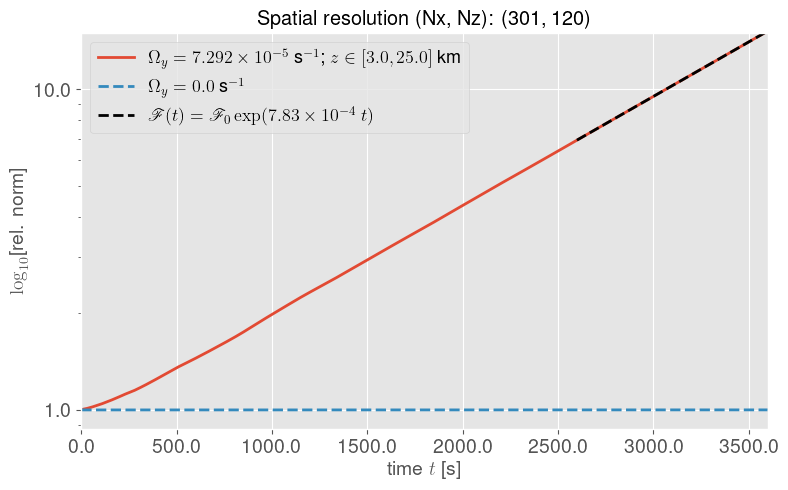

[-3.1064238556493904]


In [18]:
## from matplotlib.ticker import (FixedLocator)
from matplotlib import ticker
import matplotlib

plt.style.use('ggplot')

from numpy import linalg as la
import csv

l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

# Nxs = [151,301,601,1201]
# Nys = [60,120,240,480]
# Nxs = [120,120]
# Nys = [120,240]
# Nxs = [1201]
# Nys = [480]
Nxs = [301]
Nys = [120]

Nts = [1,2,4,8,10,12,14,16]
Nts = [10]
# Nts = np.arange(0.0, 360.0, 1.0)
# Nts = [400,600,800]
# Nts = [400]
# Nts = [1200,1400,1600]

N = 1
et = 36.0
nts = 100

tp = 'afs'
attribute = 'rhou'
tag = 'after_full_step'

mixed = False
long_run = False
fit = True
comparison = False

# choose which data points to fit.
params = [
# 151x60:
        # [2400,3600-1],
        # [1300,1800],
        # [600,900],
        # [300,450],
        [260,360],
        # [220,300],
        # [190,258],
        # [175,225],
# 301x120:
        # [0,2],
        # [0,2],
        # [0,2],
        # [4,9],
        [1,5],
        # [1,4],
        # [1,3],
        # [0,4],
# 601x240:
        # [0,2],
        # [0,2],
        # [0,2],
        # [4,8],
        # [2,5],
        # [1,4],
        # [1,3],
        # [0,4],
# 1201x480:
        # [0,2],
        # [0,2],
        # [0,2],
        # [5,9],
        # [2,6],
        # [2,3],
        # [0,2],
        # [0,2],
         ]

# params = [(3400,3600)]
# params = [(260,360)] 
# params = [(25,25)]

nexps = looper(Nxs,Nys,Nts,et,params,fs=(8,5),ftsz=14,mixed=mixed)
print(nexps)

output = False
if output:
    labels = []
    for Nx, Ny in zip(Nxs,Nys):
        for Nt in Nts:
            labels.append('%ix%i_S%i' %(Nx,Ny,Nt))
            
    f = open('params', 'a')
    writer = csv.writer(f)
    for ridx, row in enumerate(params):
        row.insert(0, labels[ridx])
        writer.writerow(row)
    f.close()

### 10hrs stable runs

test_run_S10_noadv 360.0 afs
test_run_S10_noadv 360.0 afs
SIDX; NIDX; elem.y at SIDX; elem.y at NIDX:  2 121 0.033333333333333326 7.966666666666667
SIDX; NIDX; node.y at SIDX; node.y at NIDX+1:  2 122 0.0 7.999999999999999
sz= (359, 301, 119)
Nsq= 0.017857924229847826
C= 347.4305686032822
c_p= 1005.9000000000001
-0.6765145545414872
1.1213742108218128e-06 -2.002716e-05
(359, 301, 119) (359, 301, 119)
test_run_S10_mix 360.0 afs
SIDX; NIDX; elem.y at SIDX; elem.y at NIDX:  2 121 0.033333333333333326 7.966666666666667
SIDX; NIDX; node.y at SIDX; node.y at NIDX+1:  2 122 0.0 7.999999999999999
sz= (359, 301, 119)
Nsq= 0.017857924229847826
C= 347.4305686032822
c_p= 1005.9000000000001
-7.139438094342985
-1.9694848898147308 0.021803856
(359, 301, 119) (359, 301, 119)
test_run_S10_adv 360.0 afs
SIDX; NIDX; elem.y at SIDX; elem.y at NIDX:  2 121 0.033333333333333326 7.966666666666667
SIDX; NIDX; node.y at SIDX; node.y at NIDX+1:  2 122 0.0 7.999999999999999
sz= (359, 301, 119)
Nsq= 0.017857924229

/tmp/ipykernel_57385/2864585627.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtl, fontsize=ftsz)
/tmp/ipykernel_57385/2864585627.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.around(ytl,2), fontsize=ftsz)


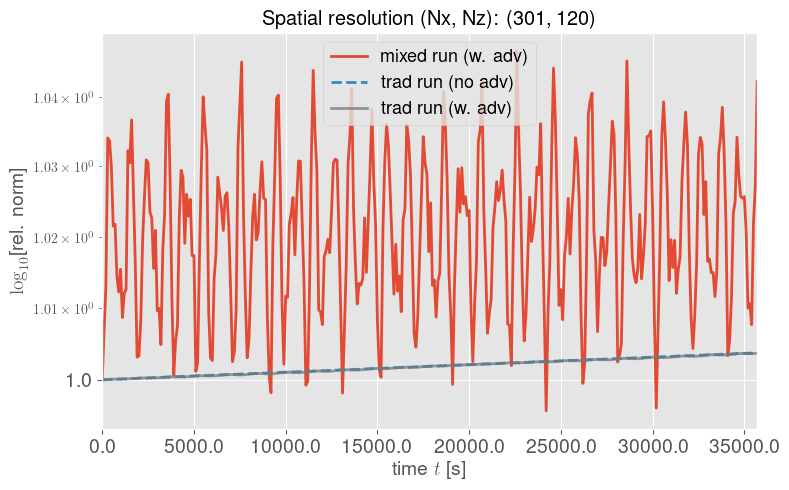

[]


In [21]:
## from matplotlib.ticker import (FixedLocator)
from matplotlib import ticker
import matplotlib

plt.style.use('ggplot')

from numpy import linalg as la
import csv

l_typ = 'TIME'
diff = False

attr_labels = pt.labels()

Nxs = [301]
Nys = [120]

Nts = np.arange(0.0, 358.0, 1.0)

N = 1
et = 360.0

tp = 'afs'
tag = 'after_full_step'

mixed = True
long_run = True
fit = False
comparison = True

params = [[0,0]] 

nexps = looper(Nxs,Nys,Nts,et,params,fs=(8,5),ftsz=14,mixed=mixed)
print(nexps)

output = False
if output:
    labels = []
    for Nx, Ny in zip(Nxs,Nys):
        for Nt in Nts:
            labels.append('%ix%i_S%i' %(Nx,Ny,Nt))
            
    f = open('params', 'a')
    writer = csv.writer(f)
    for ridx, row in enumerate(params):
        row.insert(0, labels[ridx])
        writer.writerow(row)
    f.close()

## Plot annotated heatmap in Appendix C
Note: **Restart kernel** before running these cells, otherwise the size of the figure will be affected by the settings in the above cells.

### Helper functions

In [243]:
# Results copied from the output of the above cell.
r1 = [-3.1064276399110407, -3.10619558593437, -3.1063984664306985, -3.106390680278451, -3.1063837190703034, -3.1063438977555333, -3.1063234281650343, -3.1065051655053404]
r2 = [-3.106364177302779, -3.1061871766671114, -3.1063611252719108, -3.1063952920571216, -3.1064723974421184, -3.1064081985102963, -3.106359278097276, -3.1063756198640253]
r3 = [-3.155781315264562, -3.1591213069412776, -3.2494775045481377, -3.1450322117419587, -3.1004486575658183, -3.1668084712984186, -3.1789518897034377, -3.0573811239394124]
r4 = [-3.101952599748845, -3.1007414350091307, -3.1540411190592024, -3.12239799200698, -3.117809166195433, -3.1539901222526563, -3.1685056428435363, -3.0680148571081918]

RR = np.array([r1,r2,r3,r4])
data = np.copy(10**RR) * 10**4
data = np.around(data,2)

# skip results that are restricted by CFL_{adv}
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        # skips = ((2,6),(2,7),(3,3),(3,4),(3,5),(3,6),(3,7))
        skips = ()
        for (i,j) in skips:
            data[i,j] = np.nan

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

# Annotated heatmap code modified from:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="8%", pad=0.05)
    cax1 = cax.twinx()
    cax.yaxis.set_ticks_position('right')
    cbar = plt.colorbar(im, cax=cax, **cbar_kw)

    cbar.ax.set_ylabel(cbarlabel, rotation=0)
    cbar.ax.yaxis.set_label_coords(0.9,1.075)
    cax1.grid(False, which="major")
    for j, lab in enumerate([r'$-50\%$',r'$-25\%$',r'$\pm10\%$',r'$+25\%$',r'$+50\%$']):
        cax1.text(.5, (j+0.5) / 5.0, lab, ha='center', va='center', rotation=-0)
    cax1.set_yticks([])

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-0, ha="center",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.set_xlabel("Temporal step size~[s]")
    ax.xaxis.set_label_position('top')
    ax.set_ylabel("Spatial resolution\n[number of grid points]")
    ax.grid(which="minor", color="w", linestyle='-', linewidth=4)
    ax.grid(False, which="major")
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
#     if threshold is not None:
#         threshold = im.norm(threshold)
#     else:
#         threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mtl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
#             kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
    
            # skips = ((2,6),(2,7),(3,3),(3,4),(3,5),(3,6),(3,7))
            skips = ()
            if (i,j) in skips:
                text = im.axes.text(j, i, "", **kw)
                texts.append('')
            else:
                if threshold is not None:
                    kw.update(color=textcolors[int(data[i, j] < threshold[0] or data[i, j] > threshold[1])])
                    
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
                texts.append(text)
    return texts


### Plot the annotated heatmap

[[7.83 7.83 7.83 7.83 7.83 7.83 7.83 7.83]
 [7.83 7.83 7.83 7.83 7.83 7.83 7.83 7.83]
 [6.99 6.93 5.63 7.16 7.94 6.81 6.62 8.76]
 [7.91 7.93 7.01 7.54 7.62 7.01 6.78 8.55]]


/tmp/ipykernel_4155/656621121.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


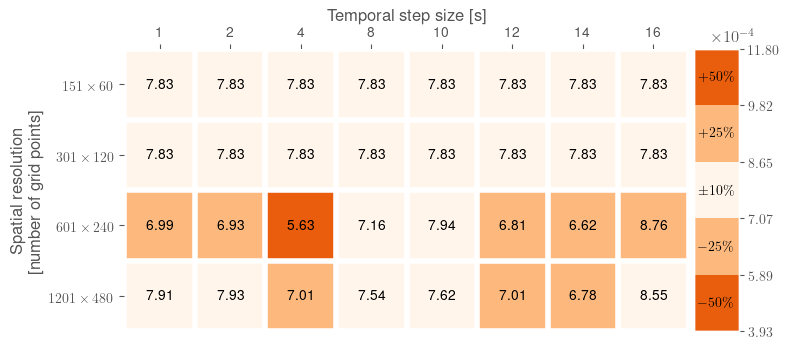

In [244]:
resos = [r'$151 \times 60$',r'$301 \times 120$',r'$601 \times 240$',r'$1201 \times 480$']
treses = [r'1',r'2',r'4',r'8',r'10',r'12',r'14',r'16']

from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-3.6, vcenter=7.85, vmax=34)
# norm = matplotlib.colors.BoundaryNorm([3.20, 3.93, 5.89, 7.07, 8.65, 9.82, 11.8, 34.0], 7)
norm = matplotlib.colors.BoundaryNorm([3.93, 5.89, 7.07, 8.65, 9.82, 11.8], 6)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 4)
middle = cm.get_cmap('Oranges_r', 1)
bottom = cm.get_cmap('Oranges', 4)

newcolors = np.vstack((top(np.linspace(0, 1, 4)[1:-1]),
                       middle(np.linspace(0, 1, 1)),
                       bottom(np.linspace(0, 1, 4)[1:-1])
                      ))
newcmp = ListedColormap(newcolors, name='OrangeDivergence')

print(data)
plt.figure(figsize=(8,8))

ax = plt.gca()
cmap = plt.get_cmap("PRGn", 5)
cmap = newcmp
cmap.set_bad(color='white', alpha = 1.)
im, cbar = heatmap(data, resos, treses, ax=ax, cmap=cmap, cbarlabel=r"$\times 10^{-4}$", norm=norm)
texts = annotate_heatmap(im, valfmt="{x:.2f}", threshold=[3.93,11.80])
plt.tight_layout()
fld_pth = './output_plot/pub'
if not os.path.exists(fld_pth):
    os.makedirs(fld_pth)
plt.savefig("%s/heatMap.pdf" %fld_pth)
plt.show()

### Compute boundaries for each colour band of the heatmap.

In [212]:
xp = -3.104615552507752

print(10**xp)

a = 0.5*10**xp
b = 1.5*10**xp
print(a,b)

a = 0.75*10**xp
b = 1.25*10**xp
print(a,b)

a = 0.90*10**xp
b = 1.10*10**xp
print(a,b)

0.0007859310510589729
0.00039296552552948647 0.0011788965765884593
0.0005894482882942296 0.0009824138138237162
0.0007073379459530757 0.0008645241561648703


1.9455260540448758
[0.0001002 0.0001022]


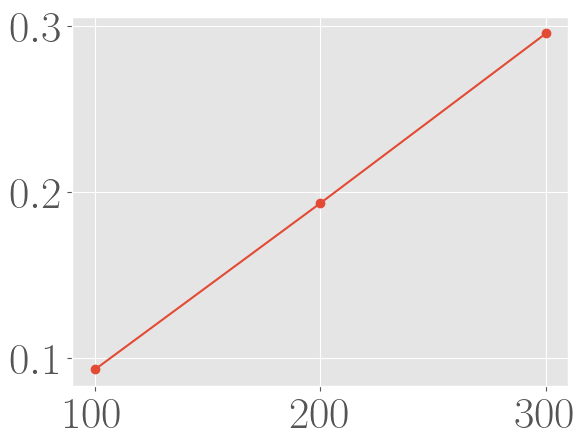

In [82]:
xx = [100,200,300]
yy = [0,1141,21310]

sol = np.array([-12.17353,1.5667,-3.4075])
up = np.array([-12.08073,1.3737,-3.1123])

Cs = 3.474305686032822
Ns = 1.7857924229847826
k = Cs / Ns

print(k)

dxs = np.abs(sol - up)

print(np.diff(dxs)/(100*10))
plt.plot(xx,dxs,'-o')